In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# Question 1
Recall discretized 1D Wiener velocity model from page $30$ of lecture $8$, where

$$
{x}_n = \begin{bmatrix} 1 & \Delta t\\
                         0 & 1\end{bmatrix} x_{n-1} + q_n, \qquad q_n \sim \mathcal{N}(0, \sigma^2_w\, \begin{bmatrix} \frac{(\Delta t)^3}{3} & \frac{(\Delta t)^2}{2} \\
                           \frac{(\Delta t)^2}{2} & \Delta t \end{bmatrix})
$$

Which corresponds to $
{x}_n = F x_{n-1} + q_n,$

#### Define the measurement matrix i.e., $y_n = G x_n + r_n$

The Wiener velocity model contains the state with position and velocity, meaning that, $x = [p, \dot{p}]^\top$.
Since we only measure the position, then we need to measure the first component of $x$
$$
y_n = \left[1 \; 0\right] x_n + r_n
$$

In [2]:
dt  = 0.1
sigma2_w = 0.1
F_wiener = np.array([ [1, dt],
                      [0, 1] ])
Q_wiener = sigma2_w * np.array([ [dt**3/3, dt**2/2],
                                [dt**2/2, dt] ])

G_wiener = np.array([[1, 0]])
R_wiener = np.array([[0.5**2]])


In [3]:
# Simulate the model
def wiener_dynamic(m0, P0, steps, F, Q):
    nx = m0.shape[0] # dimension of x
    xs = np.zeros((steps, nx))
    x_ = np.random.multivariate_normal(m0, P0)
    xs[0] = x_
    for n in range(steps):
        q = np.random.multivariate_normal(np.zeros(nx), Q)
        x_ = F @ x_ + q
        xs[n,:] = x_
    return xs

In [4]:
m0 = np.array([0, 1]) # starting from random initial state
P0 = 0.1 * np.eye(2) # starting from random initial state
t_wiener = np.arange(0, 10, dt)

xs_wiener = wiener_dynamic(m0, P0, len(t_wiener), F_wiener, Q_wiener)

r = np.random.multivariate_normal(np.zeros(1), R_wiener, len(t_wiener))
ys_wiener = xs_wiener @ G_wiener.T + r

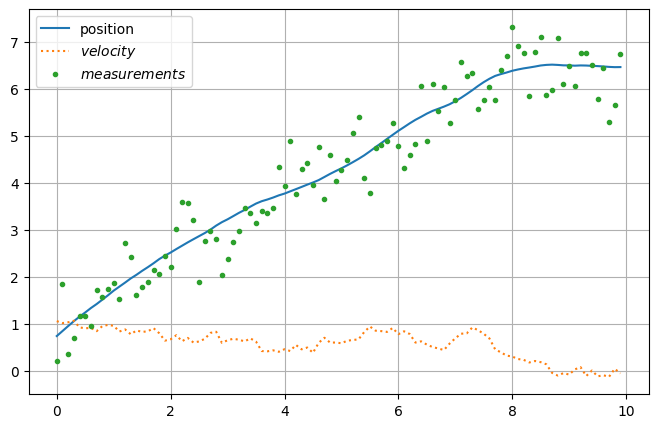

In [6]:
plt.figure(figsize=(8,5))
plt.plot(t_wiener,xs_wiener[:,0], label='position')
plt.plot(t_wiener,xs_wiener[:,1], ':', label='$velocity$')
plt.plot(t_wiener,ys_wiener[:,0],'.', label='$measurements$')
plt.legend()
plt.grid();

In [12]:
def Kalman_Filter(F, G, Q, R, Y, m0, P0):
    T = Y.shape[0]
    nx = m0.shape[0] # dimension of x
    m_kf = np.zeros((T, nx))
    P_kf = np.zeros((T, nx, nx))
    m = m0
    P = P0
    for n in range(T):
        # Prediction
        x_ = F @ m
        P_ = F @ P @ F.T + Q
        # Update
        S = G @ P_ @ G.T + R
        K = P_ @ G.T @ linalg.inv(S)
        P = P_ - K @ S @ K.T
        m = x_ + K @ (Y[n] - G @ x_)

        m_kf[n] = m
        P_kf[n] = P
    return m_kf, P_kf
    
    
    

In [13]:
x_kalman, cov_kalman = Kalman_Filter(F_wiener,G_wiener,Q_wiener,R_wiener,ys_wiener, m0, P0)

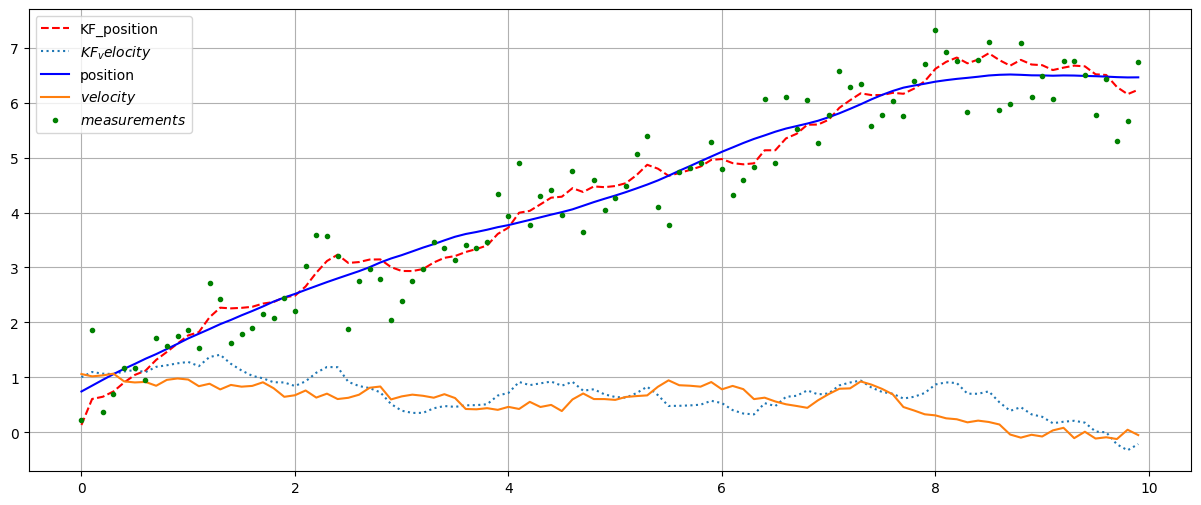

In [15]:
plt.figure(figsize=(15,6))
plt.plot(t_wiener,x_kalman[:,0],'r--', label='KF_position')
plt.plot(t_wiener,x_kalman[:,1],':', label='$KF_velocity$')
plt.plot(t_wiener,xs_wiener[:,0], 'b',  label='position')
plt.plot(t_wiener,xs_wiener[:,1], label='$velocity$')
plt.plot(t_wiener,ys_wiener[:,0],'g.', label='$measurements$')
plt.legend()
plt.grid();

In [18]:
np.sqrt(np.mean((ys_wiener[:,0] - xs_wiener[:,0])**2))


0.5035062424449739

In [19]:
np.sqrt(np.mean((x_kalman[:,0] - xs_wiener[:,0])**2))


0.2325583047988579

# Question 2

In [20]:
G = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1],
               [-1, 0, 0],
               [0, -1, 0],
               [0, 0, -1]])
L = 1
b = np.array([0, 0, 0, L, L, L])


In [21]:
x = np.array([0.3,0.4,0.5])
sigma = 0.1
R = sigma**2 * np.eye(6)
r = np.random.normal(0,sigma,6)
y = G @ x + b + r
print(y) # noisy measurements

[0.27247968 0.3220573  0.27619595 0.70223473 0.58719922 0.40190261]


# Regularized least square
$$\mathbf{x}_{ReLS} = (\mathbf{G}^\top \mathbf{R}^{-1} \mathbf{G} + \mathbf{P}^{-1})^{-1} (\mathbf{G}^\top \mathbf{R}^{-1} (\mathbf{y} - \mathbf{b}) + \mathbf{P}^{-1} \mathbf{m})$$

In [22]:
m0 = np.array([0.5,0.5,0.5])
P0 = 0.1e-2 *np.eye(3)
x_rls = linalg.inv(G.T @ linalg.inv(R) @ G + linalg.inv(P0)) @ (G.T @ linalg.inv(R) @ (y - b) + linalg.inv(P0) @ m0)
print(x_rls)

[0.46418708 0.47790484 0.48952445]


# Sequential least square


\begin{equation}
\begin{split}
    \hat{\mathbf{x}}_n &= \hat{\mathbf{x}}_{n-1} + \mathbf{K}_n(\mathbf{y}_n - \mathbf{G}_n \hat{\mathbf{x}}_{n-1})\\
    \mathbf{K}_n &= \mathbf{P}_{n-1} \mathbf{G}_n^T(\mathbf{G}_n \mathbf{P}_{n-1} \mathbf{G}_n^T + \mathbf{R}_n )^{-1}
\end{split}
\end{equation}

In [23]:
m0 = np.array([0.5,0.5,0.5]) 
P0 = 0.1e-2 *np.eye(3)   
x_sls = m0
P_sls = P0
for i in range(y.shape[0]):
    Gn = G[i:i+1,:]
    Rn = R[i,i]
    Kn = P_sls @ Gn.T @ linalg.inv(Gn @ P_sls @ Gn.T + Rn)
    x_sls = x_sls + Kn @ (y[i] - b[i] - Gn @ x_sls)
    P_sls = P_sls - Kn @ (Gn @ P_sls @ Gn.T + Rn) @ Kn.T
    print(x_sls)

[0.47931633 0.5        0.5       ]
[0.47931633 0.48382339 0.5       ]
[0.47931633 0.48382339 0.47965418]
[0.46418708 0.48382339 0.47965418]
[0.46418708 0.47790484 0.47965418]
[0.46418708 0.47790484 0.48952445]


# b)

In this case we will have the state $x = [p_x\;p_y\;p_z]^\top$. The measurement is given by
$$
y = Gx + b + r,
$$
$$
G = \begin{bmatrix}
I_3\\
-I_3
\end{bmatrix},
b = L\begin{bmatrix}
0_3\\
1_3
\end{bmatrix}.
$$

Now if we write:
$$
x_{k+1} = x_{k},
$$
$$
y_k - b = G_k x_k + r_k,
$$
where $F = I$, $Q = 0$, $G_k$ is the $k$-th row of the $G$ matrix, then we can use the Kalman filter algorithm to reproduce the regularized least square. In fact, they share the same algorithm.

In [24]:
F = np.eye(3)
Q = np.zeros((3,3))

m = m0
P = P0
for n in range(y.shape[0]):
    # Prediction
    m = F @ m
    P = F @ P @ F.T + Q
    # Update
    Gn = G[n:n+1,:] 
    S = Gn @ P @ Gn.T + R[n,n]
    K = P @ Gn.T @ linalg.inv(S)
    m = m + K @ (y[n] - b[n] - Gn @ m)
    P = P - K @ S @ K.T
    print(m)

[0.47931633 0.5        0.5       ]
[0.47931633 0.48382339 0.5       ]
[0.47931633 0.48382339 0.47965418]
[0.46418708 0.48382339 0.47965418]
[0.46418708 0.47790484 0.47965418]
[0.46418708 0.47790484 0.48952445]


# Question 3

Now the 3D wiener velocity model is given by.
$$
{x}_n = F x_{n-1} + q_n,
$$
$$
y_n = G x_n + r_n.
$$
where $x = \left[p_x, \dot{p}_x, p_y, \dot{p}_y, p_z, \dot{p}_z\right]^\top$.

Hence
$$
F = \begin{bmatrix}
    1 & dt & 0 & 0 & 0 & 0\\
    0 & 1 & 0 & 0 & 0 & 0\\
    0 & 0 & 1 & dt & 0 & 0\\
    0 & 0 & 0 & 1 & 0 & 0\\
    0 & 0 & 0 & 0 & 1 & dt\\
    0 & 0 & 0 & 0 & 0 & 1        
    \end{bmatrix},
Q = \begin{bmatrix}
    Q_1 & 0 & 0 \\
    0 & Q_1 & 0 \\
    0 & 0 & Q_1 \\
    \end{bmatrix}
$$
where $Q_1$ is the discrete process noise covariance matrix for one dimensional Wiener velocity model.
The measurement matrix is given by
$$
G = \begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0\\
    0 & 0 & 1 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & 1 & 0\\
    -1 & 0 & 0 & 0 & 0 & 0\\
    0 & 0 & -1 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & -1 & 0\\
    \end{bmatrix}
$$

In [25]:
q3  = 0.1
dt3 = 0.1
t_wiener_3d = np.arange(101)*dt3

F_1d = np.array([ [1., dt3],
                  [0., 1.]])
F_3d = linalg.block_diag(F_1d, F_1d, F_1d)

Q_1d = q3 * np.array([ [dt3**3/3, dt3**2/2], 
                       [dt3**2/2, dt3]])
Q_3d = linalg.block_diag(Q_1d, Q_1d, Q_1d)

R_3d = np.eye(6)
r_3d = np.random.multivariate_normal(np.zeros(6), R_3d, t_wiener_3d.shape[0])


G_3d = np.array([[1., 0., 0., 0., 0., 0.],
                 [0., 0., 1., 0., 0., 0.],
                 [0., 0., 0., 0., 1., 0.],
                 [-1., 0., 0., 0., 0., 0.],
                 [0., 0., -1., 0., 0., 0.],
                 [0., 0., 0., 0., -1., 0.]])


In [26]:
# model simulation
m0_ = np.array([0., 1., 0., 1., 0., 1.])
P0_ = 0.1 * np.eye(6)
x_3d = wiener_dynamic(m0_, P0_, t_wiener_3d.shape[0], F_3d, Q_3d)
y_3d = x_3d @ G_3d.T + r_3d + b

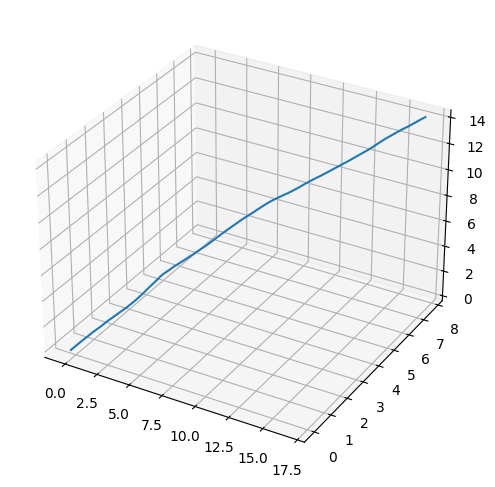

In [27]:
plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')
ax.plot3D(x_3d[:,0], x_3d[:,2], x_3d[:,4]);

In [28]:
# Kalman Filter
x_kalman_3d, cov_kalman_3d = Kalman_Filter(F_3d, G_3d, Q_3d, R_3d, y_3d - b, m0_, P0_)


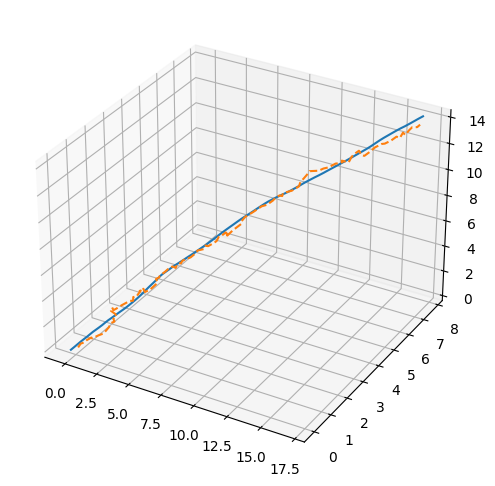

In [29]:
plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')
ax.plot3D(x_3d[:,0], x_3d[:,2], x_3d[:,4])
ax.plot3D(x_kalman_3d[:,0], x_kalman_3d[:,2], x_kalman_3d[:,4], '--');

In [30]:
#regularized least squares
P_drone = 100 * np.eye(3)# If you put P small, you better make sure that (x-m) is very close
P_drone = (P_drone+P_drone.T)/2
P_drone_inv = np.linalg.inv(P_drone)
x_reg_WLS_3d = np.empty((y_3d.shape[0],3))
x_reg_WLS_3d[0] = np.array([0,0,0])
for i in range(1, y_3d.shape[0]):
    x_reg_WLS_3d[i] = linalg.inv(G.T @ linalg.inv(R_3d) @ G + linalg.inv(P_drone)) \
                      @ (G.T @ linalg.inv(R_3d) @ (y_3d[i-1] - b) + linalg.inv(P_drone) @ x_reg_WLS_3d[0])

    

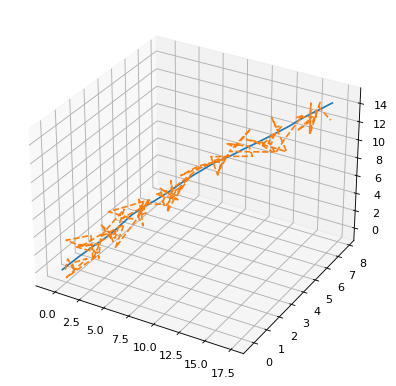

In [31]:
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(x_3d[:,0], x_3d[:,2], x_3d[:,4])
ax.plot3D(x_reg_WLS_3d[:,0], x_reg_WLS_3d[:,1], x_reg_WLS_3d[:,2], '--');

In [32]:
np.sqrt(np.mean((x_reg_WLS_3d[:,0] - x_3d[:,0])**2))


0.749245483245442

In [33]:
np.sqrt(np.mean((x_kalman_3d[:,0] - x_3d[:,0])**2))


0.3301464001402172